In [1]:
%pylab inline
import time

import pandas as pd
import anndata

import torch

from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger

from scvi.dataset import GeneExpressionDataset
from scvi.dataset import AnnDatasetFromAnnData
from scvi.models import LDVAE, VAE
from scvi.inference import UnsupervisedTrainer

import plotnine as p

Populating the interactive namespace from numpy and matplotlib


[2019-12-29 23:12:25,898] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
C:\Users\vale\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [2]:
adata = anndata.read('cao_atlas.h5ad')

In [3]:
adata.obs.head().T

index,sci3-me-001.GTCGGAGTTTGAGGTAGAA,sci3-me-001.ATTAGTCTGTGTATAATACG,sci3-me-001.GAGGAACTTAATACCATCC,sci3-me-001.TTCGCGGATACTCTCTCAA,sci3-me-001.ACTGGTTATTTGCGCCATCT
id,38,9,26,16,33
sex,F,M,F,F,M
day,13.5,11.5,10.5,13.5,12.5
Total_mRNAs,335,1989,393,227,241
tsne_1,2.50284,19.353,-15.3725,-0.750546,2.40228
tsne_2,2.58922,-5.52371,-5.7596,1.43902,12.5647
Main_Cluster,5,20,21,17,6
sub_tsne_1,0,4.01933,0,0,0
sub_tsne_2,0,18.3065,0,0,0
Sub_Cluster,unknown,1,unknown,unknown,unknown


In [4]:
adata.obs['detected_doublet'].value_counts()

False    1949131
True       77510
nan        32011
Name: detected_doublet, dtype: int64

In [5]:
adata = adata[adata.obs['detected_doublet'] == 'False']

In [6]:
cells_dataset = AnnDatasetFromAnnData(adata)

cells_dataset.subsample_genes(1000)

[2019-12-29 23:14:10,090] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-12-29 23:14:10,184] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-29 23:14:16,451] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-29 23:14:23,342] INFO - scvi.dataset.dataset | Downsampled from 1949131 to 1949131 cells
[2019-12-29 23:15:11,127] INFO - scvi.dataset.dataset | Downsampling from 26183 to 1000 genes
[2019-12-29 23:15:19,270] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-29 23:15:21,733] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2019-12-29 23:15:24,226] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-29 23:15:26,687] INFO - scvi.dataset.dataset | Downsampled from 1949131 to 1949131 cells


In [7]:
cells_dataset

GeneExpressionDataset object with n_cells x nb_genes = 1949131 x 1000
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'local_vars', 'batch_indices', 'labels', 'local_means'
    cell_categorical_attribute_names: 'batch_indices', 'labels'

In [8]:
adata.obs

,id,sex,day,Total_mRNAs,tsne_1,tsne_2,Main_Cluster,sub_tsne_1,sub_tsne_2,Sub_Cluster,db_score,detected_doublet,potential_doublet_cluster
index,,,,,,,,,,,,,
sci3-me-001.GTCGGAGTTTGAGGTAGAA,38,F,13.5,335.0,2.502835,2.589219,5.0,0.000000,0.000000,unknown,0.013367,False,nan
sci3-me-001.ATTAGTCTGTGTATAATACG,9,M,11.5,1989.0,19.352971,-5.523709,20.0,4.019330,18.306513,1,0.004160,False,False
sci3-me-001.GAGGAACTTAATACCATCC,26,F,10.5,393.0,-15.372493,-5.759600,21.0,0.000000,0.000000,unknown,0.002524,False,nan
sci3-me-001.TTCGCGGATACTCTCTCAA,16,F,13.5,227.0,-0.750546,1.439024,17.0,0.000000,0.000000,unknown,0.006938,False,nan
sci3-me-001.ACTGGTTATTTGCGCCATCT,33,M,12.5,241.0,2.402283,12.564681,6.0,0.000000,0.000000,unknown,0.002918,False,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
sci3-me-760.TCAGGAGATCGTAATGCAG,10,F,11.5,2730.0,10.383344,7.693374,15.0,9.376408,36.385473,8,0.017888,False,False
sci3-me-760.ATTCGCAATTGCCGCAACGA,21,F,9.5,1495.0,7.947955,0.975143,11.0,-2.124920,-18.627472,11,0.015518,False,False
sci3-me-760.CTAGTACGTCGTAGTTACC,4,M,10.5,2588.0,-6.156912,-3.076373,4.0,2.730012,-10.590209,18,0.121844,False,False


In [9]:
# Make the models

In [9]:
models = {}

vae = VAE(
    cells_dataset.nb_genes,
    reconstruction_loss='nb'
)

models['vae'] = vae

vae = LDVAE(
    cells_dataset.nb_genes,
    reconstruction_loss='nb',
    use_batch_norm=True,
    latent_distribution='normal'
)

models['ldvae_1'] = vae

vae = LDVAE(
    cells_dataset.nb_genes,
    reconstruction_loss='nb',
    use_batch_norm=True,
    latent_distribution='ln'
)

models['ldvae_2'] = vae

vae = LDVAE(
    cells_dataset.nb_genes,
    reconstruction_loss='nb',
    use_batch_norm=False,
    latent_distribution='normal'
)

models['ldvae_3'] = vae

vae = LDVAE(
    cells_dataset.nb_genes,
    reconstruction_loss='nb',
    use_batch_norm=False,
    latent_distribution='ln'
)

models['ldvae_4'] = vae

In [10]:
for model in models:
    vae = models[model]
    print(model)
    
    trainer = UnsupervisedTrainer(
        vae,
        cells_dataset,
        use_cuda=True,
        metrics_to_monitor=['reconstruction_error'],
        frequency=1
    )
    
    trainer.train(n_epochs=10)
    
    pd.DataFrame(trainer.history).to_csv(f'cao_vae_results/{model}_history.csv')
        
    full = trainer.create_posterior(
        trainer.model,
        cells_dataset,
        shuffle=False
    )
    
    latent, batch_indices, labels = full.get_latent()
    
    results = pd.DataFrame(latent, index=adata.obs.index)
    results.to_csv(f'cao_vae_results/{model}_Z.csv')
    
    if not model.startswith('ld'):
        continue
        
    W = vae.get_loadings()
    
    W = pd.DataFrame(W, index=cells_dataset.gene_names)
    W.to_csv(f'cao_vae_results/{model}_W.csv')

ldvae_1
training: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:54:18<00:00, 685.90s/it]


In [24]:
pd.DataFrame(latent, index=adata.obs.index)

,0,1,2,3,4,5,6,7,8,9
index,,,,,,,,,,
cell_42190,2.389662,-0.289035,-1.313911,-0.855026,1.359633,-3.787621,0.300977,-3.879475,0.497095,-2.887946
cell_54230,-0.865016,0.444213,-1.792567,-1.029466,-0.413127,2.449720,-0.943154,-2.057298,2.121359,0.366111
cell_12896,-0.451828,0.555849,-0.441126,-1.735871,0.443093,-0.112684,0.636411,-0.828022,1.179177,-0.667460
cell_64167,-0.921585,1.555387,-1.614934,-0.328591,2.248758,0.952380,0.019988,-1.749974,-0.517642,-2.332397
cell_91947,-1.046481,0.882748,-1.039052,-1.503021,1.879380,1.019206,-1.863513,-1.345181,-0.151550,-1.250503
...,...,...,...,...,...,...,...,...,...,...
cell_95423,-1.047272,0.488450,-0.337928,0.242760,1.073070,1.088385,-0.959784,-0.668254,-0.164706,-0.782132
cell_14525,1.545145,0.527564,1.101769,-0.641077,-1.961273,1.653630,-2.347091,1.023574,-0.071679,-2.099350
cell_29682,-0.005865,1.162081,-1.080778,-1.062243,-0.440175,-0.081279,-0.116921,-2.507854,1.310991,-0.138069


LDVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=1000, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(in_features=128, out_features=10, bias=True)
    (z_transformation): Softmax(dim=-1)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=1000, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=1, bias=True)

In [8]:
vae = LDVAE(
    cells_dataset.nb_genes,
    reconstruction_loss='nb',
    use_batch_norm=True,
    latent_distribution='normal'
)

In [9]:
trainer = UnsupervisedTrainer(
    vae,
    cells_dataset,
    use_cuda=True,
    metrics_to_monitor=['reconstruction_error'],
    frequency=1
)

In [10]:
trainer.train(n_epochs=50)

training: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [04:13<00:00,  5.06s/it]


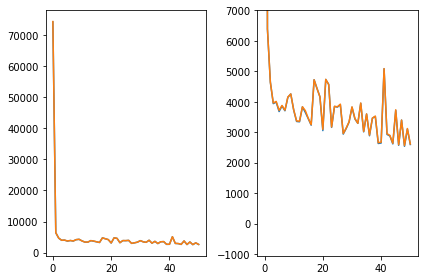

In [11]:
plt.subplot(1, 2, 1)
plt.plot(trainer.history['reconstruction_error_train_set'])
plt.plot(trainer.history['reconstruction_error_test_set'])

plt.subplot(1, 2, 2)
plt.plot(trainer.history['reconstruction_error_train_set'])
plt.plot(trainer.history['reconstruction_error_test_set'])
plt.ylim(top=7e3);

plt.tight_layout()

In [12]:
full = trainer.create_posterior(
    trainer.model,
    cells_dataset,
    shuffle=False
)

In [13]:
latent, batch_indices, labels = full.get_latent()

In [23]:
latent

array([[ 2.3896618 , -0.28903484, -1.313911  , ..., -3.8794746 ,
         0.49709463, -2.8879457 ],
       [-0.8650162 ,  0.44421327, -1.7925673 , ..., -2.0572982 ,
         2.1213593 ,  0.36611104],
       [-0.45182765,  0.5558492 , -0.44112587, ..., -0.8280225 ,
         1.1791772 , -0.66746044],
       ...,
       [-0.00586522,  1.1620814 , -1.0807776 , ..., -2.5078545 ,
         1.310991  , -0.13806915],
       [-1.3212944 ,  0.89384854, -0.3292184 , ..., -0.12721157,
         0.16445613, -1.368197  ],
       [-0.5440973 ,  0.6804408 , -0.98834133, ..., -0.7609539 ,
         0.35016537, -1.5994892 ]], dtype=float32)

In [14]:
tsne = TSNE(
    callbacks=ErrorLogger(), 
    initialization='random',
    negative_gradient_method='fft',
    callbacks_every_iters=100,
    neighbors='approx'
)

YY = tsne.fit(latent)

C:\Users\vale\Anaconda3\lib\site-packages\openTSNE\nearest_neighbors.py:184: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  "`pynndescent` has recently changed which distance metrics are supported, "
C:\Users\vale\Anaconda3\lib\site-packages\numba\ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'forest' of function 'initialise_search'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\Anaconda3\lib\site-packages\pynndescent\pynndescent_.py", line 72:
@numba.njit()
def initialise_search(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Iteration  100, KL divergence  5.3967, 100 iterations in 4.8241 sec
Iteration  200, KL divergence  4.7385, 100 iterations in 5.0576 sec
Iteration  100, KL divergence  3.1636, 100 iterations in 5.1643 sec
Iteration  200, KL divergence  2.7546, 100 iterations in 4.9548 sec
Iteration  300, KL divergence  2.5256, 100 iterations in 5.3842 sec
Iteration  400, KL divergence  2.3747, 100 iterations in 7.8257 sec
Iteration  500, KL divergence  2.2674, 100 iterations in 9.5787 sec
Iteration  600, KL divergence  2.1872, 100 iterations in 10.5149 sec
Iteration  700, KL divergence  2.1263, 100 iterations in 12.7958 sec


In [15]:
adata.obs['tsne_0'] = YY[:, 0]
adata.obs['tsne_1'] = YY[:, 1]

Trying to set attribute `.obs` of view, making a copy.


In [16]:
adata.obs.head().T

index,cell_42190,cell_54230,cell_12896,cell_64167,cell_91947
barcode,CCCAAAGACCTTCG,CATTTGACATTCTC,GCGTAAACGTTGAC,ACTTCAACTCCGAA,AGGAACCTTGTCCC
sample,18,21,9,24,28
stage,E6.5,mixed_gastrulation,E7.75,E8.25,E8.25
sequencing.batch,2,2,1,2,2
theiler,TS9,TS9-10,TS11,TS12,TS12
doub.density,0.0417069,0.552246,0.0678092,2.13599,0.299039
doublet,False,False,False,False,False
cluster,1,12,1,16,10
cluster.sub,5,4,3,10,2
cluster.stage,6,10,9,6,12


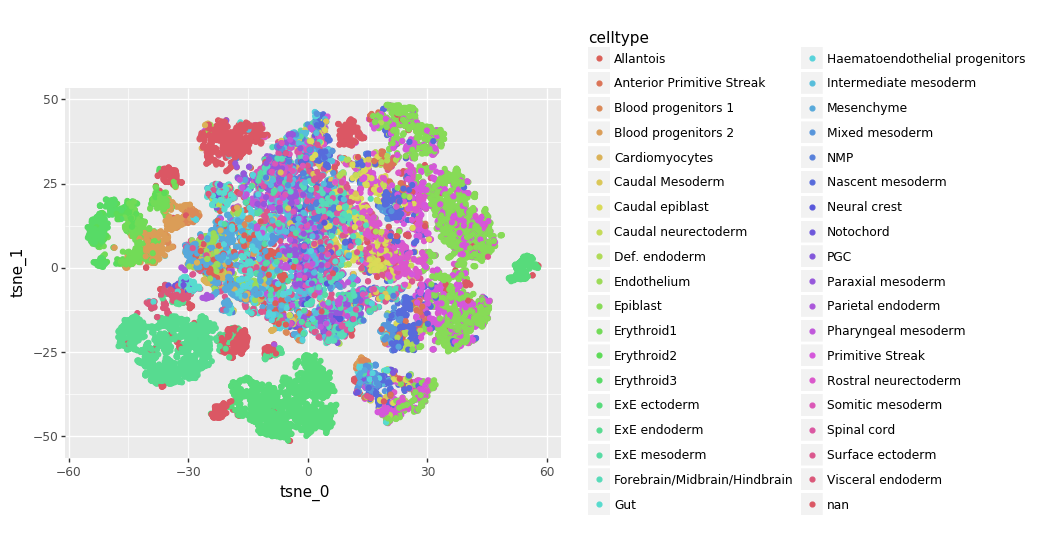

<ggplot: (-9223371864895931964)>

In [17]:
(
    p.ggplot(
        p.aes(x='tsne_0', y='tsne_1', color='celltype'),
        adata.obs
    )
    + p.geom_point()
)


In [8]:
# Lognorm latent distribution

In [9]:
vae = LDVAE(
    cells_dataset.nb_genes,
    reconstruction_loss='nb',
    use_batch_norm=True,
    latent_distribution='ln'
)

In [10]:
trainer = UnsupervisedTrainer(
    vae,
    cells_dataset,
    use_cuda=True,
    metrics_to_monitor=['reconstruction_error'],
    frequency=1
)

In [11]:
trainer.train(n_epochs=50)

training: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [04:21<00:00,  5.24s/it]


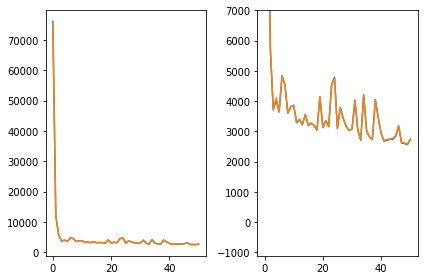

In [12]:
plt.subplot(1, 2, 1)
plt.plot(trainer.history['reconstruction_error_train_set'])
plt.plot(trainer.history['reconstruction_error_test_set'])

plt.subplot(1, 2, 2)
plt.plot(trainer.history['reconstruction_error_train_set'])
plt.plot(trainer.history['reconstruction_error_test_set'])
plt.ylim(top=7e3);

plt.tight_layout()

In [21]:
full = trainer.create_posterior(
    trainer.model,
    cells_dataset,
    shuffle=False
)

In [23]:
tsne = TSNE(
    callbacks=ErrorLogger(), 
    initialization='random',
    negative_gradient_method='fft',
    callbacks_every_iters=100,
    neighbors='approx'
)

YY = tsne.fit(latent)

C:\Users\vale\Anaconda3\lib\site-packages\openTSNE\nearest_neighbors.py:184: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  "`pynndescent` has recently changed which distance metrics are supported, "


Iteration  100, KL divergence  5.4474, 100 iterations in 5.3722 sec
Iteration  200, KL divergence  4.5519, 100 iterations in 5.0610 sec
Iteration  100, KL divergence  3.0834, 100 iterations in 4.9288 sec
Iteration  200, KL divergence  2.6755, 100 iterations in 5.2968 sec
Iteration  300, KL divergence  2.4436, 100 iterations in 5.0525 sec
Iteration  400, KL divergence  2.2898, 100 iterations in 7.2386 sec
Iteration  500, KL divergence  2.1795, 100 iterations in 8.8843 sec
Iteration  600, KL divergence  2.0972, 100 iterations in 10.3450 sec
Iteration  700, KL divergence  2.0350, 100 iterations in 11.9075 sec


In [24]:
adata.obs['tsne_0'] = YY[:, 0]
adata.obs['tsne_1'] = YY[:, 1]

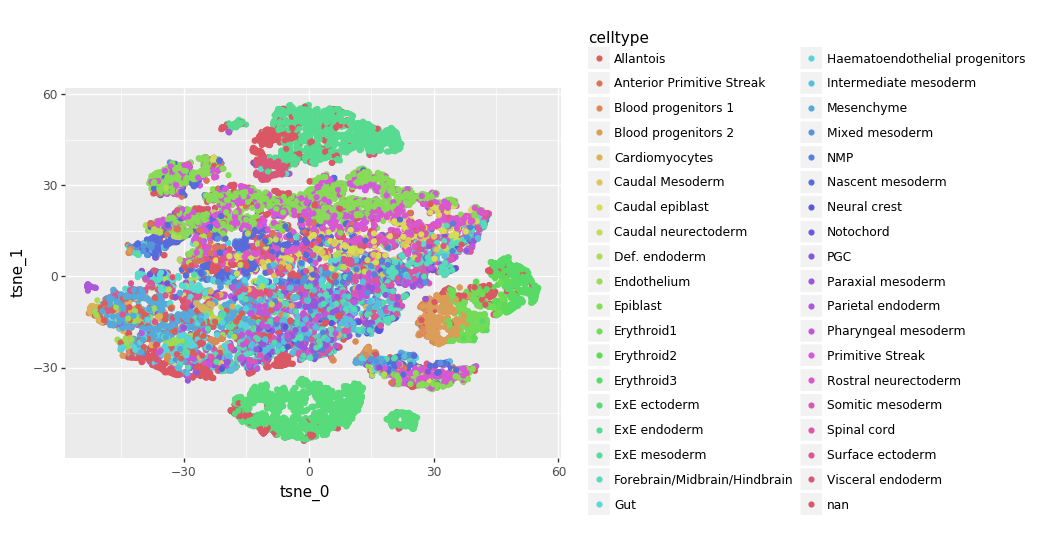

<ggplot: (-9223371938268017032)>

In [25]:
(
    p.ggplot(
        p.aes(x='tsne_0', y='tsne_1', color='celltype'),
        adata.obs
    )
    + p.geom_point()
)


In [28]:
W = vae.get_loadings()

In [31]:
latent.shape

(20000, 10)

In [39]:
for i, z in enumerate(latent.T):
    adata.obs[f'z{i}'] = z

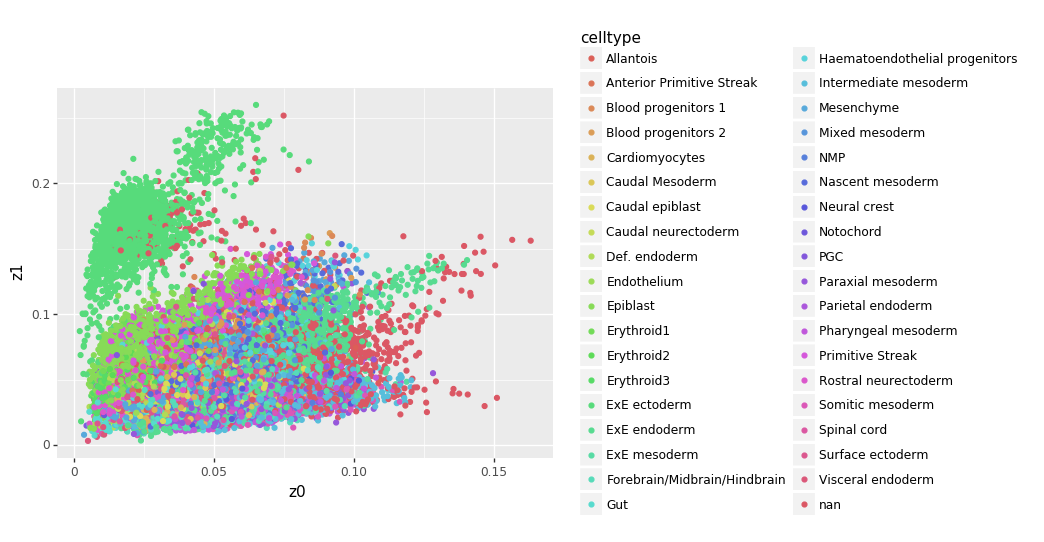

<ggplot: (-9223371938401201684)>

In [51]:
(
    p.ggplot(
        p.aes(x='z0', y='z1', color='celltype'),
        adata.obs
    )
    + p.geom_point()
)


In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
XX = pca.fit_transform(latent)

In [54]:
for i, xx in enumerate(XX.T):
    adata.obs[f'PC_{i}'] = xx

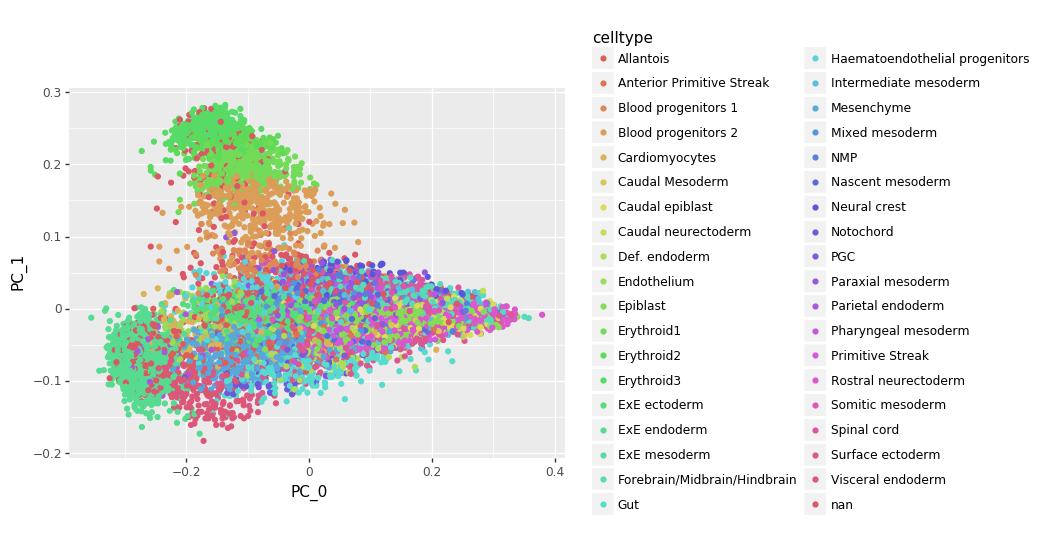

<ggplot: (-9223371938268001012)>

In [55]:
(
    p.ggplot(
        p.aes(x='PC_0', y='PC_1', color='celltype'),
        adata.obs
    )
    + p.geom_point()
)
